In [2]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(400_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
E0328 18:49:38.340819436    1043 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0328 18:49:40.711410030    1043 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [3]:
pbar = tqdm()

0it [00:00, ?it/s]

In [4]:
analysis_date = dt.date(2022, 3, 23) ##wednesday, new tables
lbt_itp_id = 170

In [7]:
%%capture
rt_day = rt.OperatorDayAnalysis(lbt_itp_id, analysis_date, pbar)

In [10]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00')
m = rt_day.segment_speed_map(how='low_speeds', size = [1300, 700])

In [9]:
m

### Investigate lbt odd shapes

In [15]:
lines = utils.get_routelines(lbt_itp_id, analysis_date).dropna()

/opt/conda/lib/python3.9/site-packages/pybigquery/sqlalchemy_bigquery.py:879: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:38: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


In [16]:
lines['num_points'] = lines.geometry.apply(lambda x: len([pt for pt in x.coords]))

In [17]:
lines['has_trip'] = lines.shape_id.isin(rt_day.rt_trips.shape_id)

In [18]:
lines >> filter(_.num_points < 80) >> arrange(_.num_points)

calitp_itp_id  calitp_url_number calitp_extracted_at calitp_deleted_at  \
14             170                  0          2021-12-14        2099-01-01   
17             170                  0          2021-12-14        2099-01-01   
24             170                  0          2021-12-14        2099-01-01   
13             170                  0          2021-12-14        2099-01-01   
1              170                  0          2021-12-14        2099-01-01   
3              170                  0          2021-12-14        2099-01-01   
22             170                  0          2021-12-14        2099-01-01   
21             170                  0          2021-12-14        2099-01-01   
28             170                  0          2021-12-14        2099-01-01   
10             170                  0          2021-12-14        2099-01-01   
23             170                  0          2021-12-14        2099-01-01   
12             170                  0          2021-12-14        2099-01-01   
15             170                  0          2021-12-14        2099-01-01   
29             170                  0          2021-12-14        2099-01-01   
30             170                  0          2021-12-14        2099-01-01   
4              170                  0          2021-12-14        2099-01-01   
5              170                  0          2021-12-14        2099-01-01   
11             170                  0          2021-12-14        2099-01-01   
19             170                  0          2021-12-14        2099-01-01   
27             170                  0          2021-12-14        2099-01-01   
7              170                  0          2021-12-14        2099-01-01   
2              170                  0          2021-12-14        2099-01-01   
6              170                  0          2021-12-14        2099-01-01   
8              170                  0          2021-12-14        2099-01-01   
49             170                  0          2021-05-13        2099-01-01   
42             170                  0          2021-05-13        2099-01-01   
48             170                  0          2021-05-13        2099-01-01   
26             170                  0          2021-12-14        2099-01-01   
32             170                  0          2021-05-13        2099-01-01   
37             170                  0          2021-05-13        2099-01-01   
244            170                  0          2021-09-16        2099-01-01   
116            170                  0          2022-02-01        2099-01-01   

    shape_id                                           geometry  num_points  \
14    610105  LINESTRING (168050.092 -464617.432, 168050.092...           2   
17   1740030  LINESTRING (168982.728 -467847.436, 169029.505...           2   
24   1810081  LINESTRING (167193.543 -470028.886, 166971.226...           2   
13   1510067  LINESTRING (167073.025 -470031.290, 166971.226...           3   
1    1030063  LINESTRING (173102.310 -461425.826, 173102.310...           4   
3    1910287  LINESTRING (174799.552 -461399.277, 174799.552...           4   
22   1720090  LINESTRING (168982.728 -467847.436, 169029.505...           4   
21    460063  LINESTRING (170572.064 -468622.735, 170587.532...           5   
28    460064  LINESTRING (170572.064 -468622.735, 170587.532...           5   
10    450110  LINESTRING (170787.414 -468618.771, 170769.170...           6   
23    460065  LINESTRING (170787.414 -468618.771, 170769.170...           6   
12   1720091  LINESTRING (168517.741 -467857.704, 168185.890...           7   
15   1210144  LINESTRING (174259.192 -469459.299, 174435.009...           9   
29   1030064  LINESTRING (171583.902 -463088.889, 171610.942...           9   
30   1720092  LINESTRING (168982.728 -467847.436, 169029.505...           9   
4     410006  LINESTRING (167076.954 -468688.931, 167104.467...          10   
5     410008  LINESTRING (167076.954 -468688.931, 1671

In [23]:
a_shape = lines >> filter(_.shape_id == '1720090')

In [24]:
a_shape

calitp_itp_id  calitp_url_number calitp_extracted_at calitp_deleted_at  \
22             170                  0          2021-12-14        2099-01-01   
46             170                  0          2021-05-13        2099-01-01   
195            170                  0          2022-02-02        2099-01-01   

    shape_id                                           geometry  num_points  \
22   1720090  LINESTRING (168982.728 -467847.436, 169029.505...           4   
46   1720090  LINESTRING (167588.400 -470295.427, 167757.977...         183   
195  1720090  LINESTRING (167579.235 -470295.935, 167595.529...         670   

     has_trip  
22       True  
46       True  
195      True

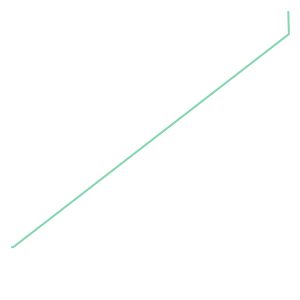

In [25]:
## this isn't correct...
too_straight = a_shape.geometry.iloc[0]
too_straight

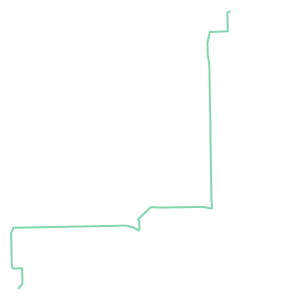

In [28]:
## this looks OK
a_shape.geometry.iloc[1]

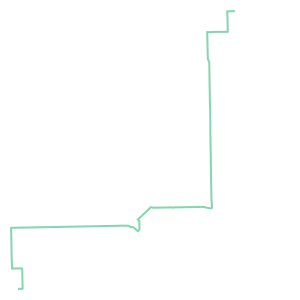

In [29]:
## this looks OK too
a_shape.geometry.iloc[2]

### another shape

In [30]:
shape2 = lines >> filter(_.shape_id == '1030063')

In [31]:
shape2

calitp_itp_id  calitp_url_number calitp_extracted_at calitp_deleted_at  \
1              170                  0          2021-12-14        2099-01-01   
44             170                  0          2021-05-13        2099-01-01   
210            170                  0          2022-02-02        2099-01-01   

    shape_id                                           geometry  num_points  \
1    1030063  LINESTRING (173102.310 -461425.826, 173102.310...           4   
44   1030063  LINESTRING (171924.612 -460936.065, 171923.003...         168   
210  1030063  LINESTRING (171925.408 -460990.847, 171922.908...         422   

     has_trip  
1        True  
44       True  
210      True

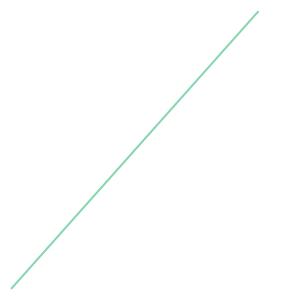

In [32]:
shape2.geometry.iloc[0]

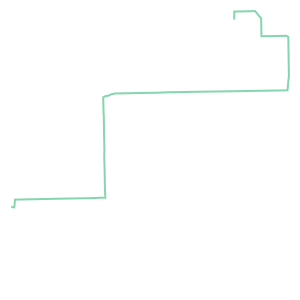

In [33]:
shape2.geometry.iloc[1]

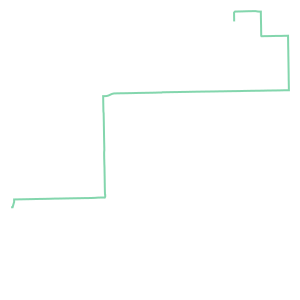

In [34]:
shape2.geometry.iloc[2]